## Import data on site, nonsite, and prediction csvs
may need to drop a few columns

In [1]:
from randomSiteSampling import randomSamplingFromDF
from randomSiteSampling import randomSamplingFromCSV

from plotPredicted import plotPredictedFromDF
from plotPredicted import plotPredictedFromCSV

In [2]:
import numpy as np
import pandas as pd
import sklearn as ml
import matplotlib
%matplotlib inline

import pprint
pp = pprint.PrettyPrinter(indent=4).pprint

"""
Importing data
"""
raw_site_file = 'common_sites_V3.csv'
raw_pred_file = 'ireland_sites_V3.csv'

raw_site_df = pd.read_csv(raw_site_file, low_memory=False, error_bad_lines=False, encoding='ISO-8859-1')
raw_pred_df = pd.read_csv(raw_pred_file, low_memory=False, error_bad_lines=False, encoding='ISO-8859-1')

site_df = raw_site_df.copy()
nonsite_df, pred_df = randomSamplingFromDF(raw_site_df, raw_pred_df)

ireland_site_df = site_df.where(site_df['country'] == 'Ireland')

"""
Making sure all dataframes have the same columns
We do this by finding all the columns which are
not shared between all dataframes. We then keep
only the columns common to all the dataframes
"""
site_attr = set(site_df)
nonsite_attr = set(nonsite_df)
pred_attr = set(pred_df)

common_attr = site_attr & nonsite_attr & pred_attr
uncommon_attr = (site_attr | nonsite_attr | pred_attr) - common_attr

drop_site = site_attr & uncommon_attr
drop_nonsite = nonsite_attr & uncommon_attr
drop_pred = pred_attr & uncommon_attr

# drop columns
site_df = site_df.drop(columns=drop_site)
nonsite_df = nonsite_df.drop(columns=drop_nonsite)
pred_df = pred_df.drop(columns=drop_pred)

"""
Take care of na values by propogating values forward then backward
"""
site_df = site_df.fillna(method='ffill').fillna(method='bfill')
nonsite_df = nonsite_df.fillna(method='ffill').fillna(method='bfill')
pred_df = pred_df.fillna(method='ffill').fillna(method='bfill')

# Combining our site and nonsite data

In [3]:
site_df['site'] = 1
nonsite_df['site'] = 0
data = pd.concat([site_df, nonsite_df])

target = data['site']
data = data.drop(columns=['site'])

# Splitting the Data into Training and Test Sets

In [4]:
from sklearn.model_selection import train_test_split

train_size=0.7

train_data, test_data, train_target, test_target = train_test_split(data, target, train_size=train_size)

/Users/WillC/miniconda2/envs/ML/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train using Different Models

### 1. Linear SVC Model

## The 'predictions' dataframe will be used  to store the results of the following training models

In [5]:
predictions = pred_df.copy(deep=True)

# 1. Training the Linear SVC Model

In [6]:
from sklearn import svm

SVCModel = svm.SVC(kernel='linear', C=1.0)
SVCModel.fit(train_data, train_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Testing the Linear SVC Model

In [7]:
from sklearn import metrics

model = SVCModel
"""
Fit the training data
and observe the metrics
"""
preds = model.predict(train_data)
targs = train_target
args = (targs, preds)
print "Training Data"
print "accuracy:  ", metrics.accuracy_score(*args)
print "precision: ", metrics.precision_score(*args)
print "recall:    ", metrics.recall_score(*args)
print "f1:        ", metrics.f1_score(*args)
# print("area under curve (auc): ", metrics.roc_auc_score(*args))


"""
Fit the test data
and observe the metrics
"""
preds = model.predict(test_data)
targs = test_target
args = (targs, preds)
print "\n"
print "Test Data"
print "accuracy:  ", metrics.accuracy_score(*args)
print "precision: ", metrics.precision_score(*args)
print "recall:    ", metrics.recall_score(*args)
print "f1:        ", metrics.f1_score(*args)
# print("area under curve (auc): ", metrics.roc_auc_score(*args))

Training Data
accuracy:   0.863123236124
precision:  0.96004842615
recall:     0.754519505233
f1:         0.844965370272


Test Data
accuracy:   0.825657894737
precision:  0.950437317784
recall:     0.696581196581
f1:         0.803945745993


## Linear SVC Prediction

('Sites exists:     ', 22839)
('Sites dn exists: ', 636098)
Percentage of sites predicted having an archeological site
('0.03466', '%')


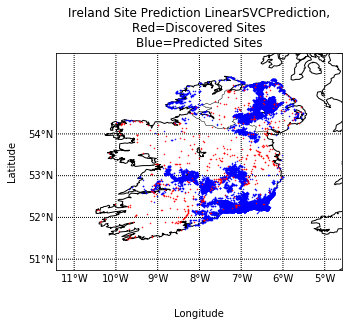

In [10]:
model_name = 'LinearSVCPrediction'
predictions[model_name] = SVCModel.predict(pred_df)

site_exists = predictions[predictions[model_name] == 1]
site_nexists = predictions[predictions[model_name] != 1]

print('Sites exists:     ', site_exists[model_name].count())
print('Sites dn exists: ', site_nexists[model_name].count())

print('Percentage of sites predicted having an archeological site')
print('%.5f' % (float(site_exists[model_name].count())/float(predictions[model_name].count())), '%')

predictions.LinearSVCPrediction.value_counts().plot(kind='bar')  
plotPredictedFromDF(raw_site_df, predictions, model_name=model_name)